[I 2024-09-06 08:49:18,448] A new study created in memory with name: no-name-deaef50a-2eef-4982-aa83-76a1a59c8217


1/1 [==============================] - 0s 104ms/step


[I 2024-09-06 08:49:54,842] Trial 0 finished with value: 0.8724747474747476 and parameters: {'n_layers': 1, 'n_units_l0': 24, 'activation_l0': 'relu', 'optimizer': 'adam', 'batch_size': 20, 'epochs': 17}. Best is trial 0 with value: 0.8724747474747476.


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:49:55,533] Trial 1 finished with value: 0.28935185185185175 and parameters: {'n_layers': 3, 'n_units_l0': 116, 'activation_l0': 'tanh', 'n_units_l1': 9, 'activation_l1': 'tanh', 'n_units_l2': 31, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 47, 'epochs': 13}. Best is trial 1 with value: 0.28935185185185175.


1/1 [==============================] - 0s 71ms/step


[I 2024-09-06 08:49:56,491] Trial 2 finished with value: 0.0636363636363636 and parameters: {'n_layers': 3, 'n_units_l0': 56, 'activation_l0': 'tanh', 'n_units_l1': 112, 'activation_l1': 'tanh', 'n_units_l2': 11, 'activation_l2': 'tanh', 'optimizer': 'adam', 'batch_size': 26, 'epochs': 20}. Best is trial 2 with value: 0.0636363636363636.


1/1 [==============================] - 0s 57ms/step


[I 2024-09-06 08:49:57,149] Trial 3 finished with value: 0.23703703703703716 and parameters: {'n_layers': 1, 'n_units_l0': 82, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 34, 'epochs': 11}. Best is trial 2 with value: 0.0636363636363636.


1/1 [==============================] - 0s 49ms/step


[I 2024-09-06 08:49:58,007] Trial 4 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'activation_l0': 'tanh', 'n_units_l1': 12, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 61, 'epochs': 42}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:49:59,039] Trial 5 finished with value: 0.06481481481481488 and parameters: {'n_layers': 3, 'n_units_l0': 55, 'activation_l0': 'tanh', 'n_units_l1': 12, 'activation_l1': 'relu', 'n_units_l2': 25, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 20}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 72ms/step


[I 2024-09-06 08:49:59,995] Trial 6 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 60, 'activation_l0': 'relu', 'n_units_l1': 53, 'activation_l1': 'relu', 'n_units_l2': 85, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 41, 'epochs': 44}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 56ms/step


[I 2024-09-06 08:50:00,780] Trial 7 finished with value: 0.22377622377622375 and parameters: {'n_layers': 1, 'n_units_l0': 100, 'activation_l0': 'relu', 'optimizer': 'sgd', 'batch_size': 28, 'epochs': 25}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:01,901] Trial 8 finished with value: 0.28935185185185175 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'activation_l0': 'relu', 'n_units_l1': 72, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 16, 'epochs': 26}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 40ms/step


[I 2024-09-06 08:50:02,734] Trial 9 finished with value: 0.0636363636363636 and parameters: {'n_layers': 1, 'n_units_l0': 38, 'activation_l0': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 32, 'epochs': 20}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 47ms/step


[I 2024-09-06 08:50:03,640] Trial 10 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'activation_l0': 'tanh', 'n_units_l1': 48, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 64, 'epochs': 41}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:50:04,562] Trial 11 finished with value: 0.25589225589225606 and parameters: {'n_layers': 2, 'n_units_l0': 82, 'activation_l0': 'relu', 'n_units_l1': 53, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 49, 'epochs': 50}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 53ms/step


[I 2024-09-06 08:50:05,434] Trial 12 finished with value: 0.33986928104575176 and parameters: {'n_layers': 3, 'n_units_l0': 86, 'activation_l0': 'relu', 'n_units_l1': 34, 'activation_l1': 'tanh', 'n_units_l2': 117, 'activation_l2': 'relu', 'optimizer': 'sgd', 'batch_size': 64, 'epochs': 39}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:50:06,336] Trial 13 finished with value: 0.23703703703703716 and parameters: {'n_layers': 2, 'n_units_l0': 40, 'activation_l0': 'relu', 'n_units_l1': 79, 'activation_l1': 'relu', 'optimizer': 'adam', 'batch_size': 55, 'epochs': 38}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:07,623] Trial 14 finished with value: 0.06481481481481488 and parameters: {'n_layers': 2, 'n_units_l0': 68, 'activation_l0': 'relu', 'n_units_l1': 101, 'activation_l1': 'relu', 'optimizer': 'rmsprop', 'batch_size': 42, 'epochs': 48}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 53ms/step


[I 2024-09-06 08:50:08,592] Trial 15 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 106, 'activation_l0': 'tanh', 'n_units_l1': 33, 'activation_l1': 'tanh', 'n_units_l2': 94, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 55, 'epochs': 33}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 47ms/step


[I 2024-09-06 08:50:09,438] Trial 16 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 67, 'activation_l0': 'tanh', 'n_units_l1': 89, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 40, 'epochs': 44}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:50:10,478] Trial 17 finished with value: 0.22377622377622375 and parameters: {'n_layers': 3, 'n_units_l0': 95, 'activation_l0': 'relu', 'n_units_l1': 28, 'activation_l1': 'tanh', 'n_units_l2': 73, 'activation_l2': 'tanh', 'optimizer': 'adam', 'batch_size': 57, 'epochs': 34}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:50:11,416] Trial 18 finished with value: 0.06481481481481488 and parameters: {'n_layers': 2, 'n_units_l0': 45, 'activation_l0': 'relu', 'n_units_l1': 54, 'activation_l1': 'tanh', 'optimizer': 'sgd', 'batch_size': 40, 'epochs': 45}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 57ms/step


[I 2024-09-06 08:50:12,509] Trial 19 finished with value: 0.06481481481481488 and parameters: {'n_layers': 3, 'n_units_l0': 124, 'activation_l0': 'tanh', 'n_units_l1': 126, 'activation_l1': 'relu', 'n_units_l2': 61, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 49, 'epochs': 33}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


h:\Anaconda\envs\IA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-06 08:50:13,373] Trial 20 finished with value: 1.0703871292106588 and parameters: {'n_layers': 2, 'n_units_l0': 4, 'activation_l0': 'tanh', 'n_units_l1': 19, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 59, 'epochs': 44}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:14,101] Trial 21 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 127, 'activation_l0': 'tanh', 'n_units_l1': 52, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 64, 'epochs': 40}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 48ms/step


[I 2024-09-06 08:50:14,809] Trial 22 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 106, 'activation_l0': 'tanh', 'n_units_l1': 43, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 60, 'epochs': 41}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:50:15,764] Trial 23 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 116, 'activation_l0': 'tanh', 'n_units_l1': 66, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 52, 'epochs': 46}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 39ms/step


[I 2024-09-06 08:50:16,400] Trial 24 finished with value: 0.06481481481481488 and parameters: {'n_layers': 1, 'n_units_l0': 74, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 61, 'epochs': 37}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:50:17,075] Trial 25 finished with value: 0.1742424242424242 and parameters: {'n_layers': 2, 'n_units_l0': 115, 'activation_l0': 'tanh', 'n_units_l1': 62, 'activation_l1': 'tanh', 'optimizer': 'sgd', 'batch_size': 44, 'epochs': 29}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 54ms/step


[I 2024-09-06 08:50:18,043] Trial 26 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 92, 'activation_l0': 'relu', 'n_units_l1': 23, 'activation_l1': 'relu', 'n_units_l2': 126, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 52, 'epochs': 42}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 47ms/step


[I 2024-09-06 08:50:18,993] Trial 27 finished with value: 0.1212121212121211 and parameters: {'n_layers': 2, 'n_units_l0': 127, 'activation_l0': 'tanh', 'n_units_l1': 41, 'activation_l1': 'tanh', 'optimizer': 'sgd', 'batch_size': 36, 'epochs': 50}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 61ms/step


[I 2024-09-06 08:50:19,717] Trial 28 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 54, 'activation_l0': 'relu', 'n_units_l1': 85, 'activation_l1': 'relu', 'optimizer': 'adam', 'batch_size': 63, 'epochs': 37}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 44ms/step


[I 2024-09-06 08:50:20,742] Trial 29 finished with value: 0.12535612535612528 and parameters: {'n_layers': 1, 'n_units_l0': 28, 'activation_l0': 'relu', 'optimizer': 'rmsprop', 'batch_size': 24, 'epochs': 35}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 50ms/step


[I 2024-09-06 08:50:21,892] Trial 30 finished with value: 0.1212121212121211 and parameters: {'n_layers': 3, 'n_units_l0': 107, 'activation_l0': 'tanh', 'n_units_l1': 47, 'activation_l1': 'tanh', 'n_units_l2': 59, 'activation_l2': 'tanh', 'optimizer': 'adam', 'batch_size': 57, 'epochs': 47}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:50:22,885] Trial 31 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 107, 'activation_l0': 'tanh', 'n_units_l1': 35, 'activation_l1': 'tanh', 'n_units_l2': 90, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 53, 'epochs': 32}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:50:24,005] Trial 32 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 113, 'activation_l0': 'tanh', 'n_units_l1': 4, 'activation_l1': 'tanh', 'n_units_l2': 98, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 57, 'epochs': 42}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 49ms/step


[I 2024-09-06 08:50:24,810] Trial 33 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 123, 'activation_l0': 'tanh', 'n_units_l1': 19, 'activation_l1': 'tanh', 'n_units_l2': 95, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 46, 'epochs': 29}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:50:25,648] Trial 34 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 99, 'activation_l0': 'tanh', 'n_units_l1': 33, 'activation_l1': 'tanh', 'n_units_l2': 79, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 61, 'epochs': 36}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 53ms/step


[I 2024-09-06 08:50:26,586] Trial 35 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 74, 'activation_l0': 'tanh', 'n_units_l1': 57, 'activation_l1': 'tanh', 'n_units_l2': 112, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 54, 'epochs': 43}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:27,384] Trial 36 finished with value: 0.33986928104575176 and parameters: {'n_layers': 2, 'n_units_l0': 118, 'activation_l0': 'tanh', 'n_units_l1': 26, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 59, 'epochs': 40}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:50:28,100] Trial 37 finished with value: 0.23703703703703716 and parameters: {'n_layers': 3, 'n_units_l0': 89, 'activation_l0': 'tanh', 'n_units_l1': 13, 'activation_l1': 'tanh', 'n_units_l2': 105, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 49, 'epochs': 26}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 48ms/step


[I 2024-09-06 08:50:28,708] Trial 38 finished with value: 0.0 and parameters: {'n_layers': 1, 'n_units_l0': 62, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 38, 'epochs': 17}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:29,518] Trial 39 finished with value: 0.28935185185185175 and parameters: {'n_layers': 2, 'n_units_l0': 103, 'activation_l0': 'relu', 'n_units_l1': 39, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 29, 'epochs': 32}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 50ms/step


[I 2024-09-06 08:50:31,233] Trial 40 finished with value: 0.1212121212121211 and parameters: {'n_layers': 3, 'n_units_l0': 77, 'activation_l0': 'tanh', 'n_units_l1': 15, 'activation_l1': 'tanh', 'n_units_l2': 51, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 23, 'epochs': 48}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:32,089] Trial 41 finished with value: 0.33986928104575176 and parameters: {'n_layers': 2, 'n_units_l0': 52, 'activation_l0': 'tanh', 'n_units_l1': 91, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 36, 'epochs': 44}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:50:32,827] Trial 42 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 61, 'activation_l0': 'tanh', 'n_units_l1': 74, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 43, 'epochs': 39}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:33,562] Trial 43 finished with value: 0.0636363636363636 and parameters: {'n_layers': 2, 'n_units_l0': 111, 'activation_l0': 'tanh', 'n_units_l1': 102, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 40, 'epochs': 46}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:34,508] Trial 44 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 29, 'activation_l0': 'tanh', 'n_units_l1': 62, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 32, 'epochs': 42}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:50:35,221] Trial 45 finished with value: 0.28935185185185175 and parameters: {'n_layers': 2, 'n_units_l0': 121, 'activation_l0': 'relu', 'n_units_l1': 47, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 46, 'epochs': 24}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 95ms/step


[I 2024-09-06 08:50:36,826] Trial 46 finished with value: 0.06481481481481488 and parameters: {'n_layers': 2, 'n_units_l0': 47, 'activation_l0': 'tanh', 'n_units_l1': 6, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 16, 'epochs': 50}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:50:38,034] Trial 47 finished with value: 0.0 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'activation_l0': 'relu', 'n_units_l1': 70, 'activation_l1': 'relu', 'optimizer': 'rmsprop', 'batch_size': 63, 'epochs': 44}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 49ms/step


[I 2024-09-06 08:50:38,927] Trial 48 finished with value: 0.0 and parameters: {'n_layers': 3, 'n_units_l0': 83, 'activation_l0': 'tanh', 'n_units_l1': 31, 'activation_l1': 'tanh', 'n_units_l2': 81, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 56, 'epochs': 38}. Best is trial 4 with value: 0.0.


1/1 [==============================] - 0s 46ms/step


h:\Anaconda\envs\IA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-09-06 08:50:39,460] Trial 49 finished with value: 0.8166666666666667 and parameters: {'n_layers': 2, 'n_units_l0': 67, 'activation_l0': 'relu', 'n_units_l1': 116, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 50, 'epochs': 11}. Best is trial 4 with value: 0.0.


Best parameters: {'n_layers': 2, 'n_units_l0': 112, 'activation_l0': 'tanh', 'n_units_l1': 12, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 61, 'epochs': 42}
Best trial precision: 1.0
Best trial recall: 1.0


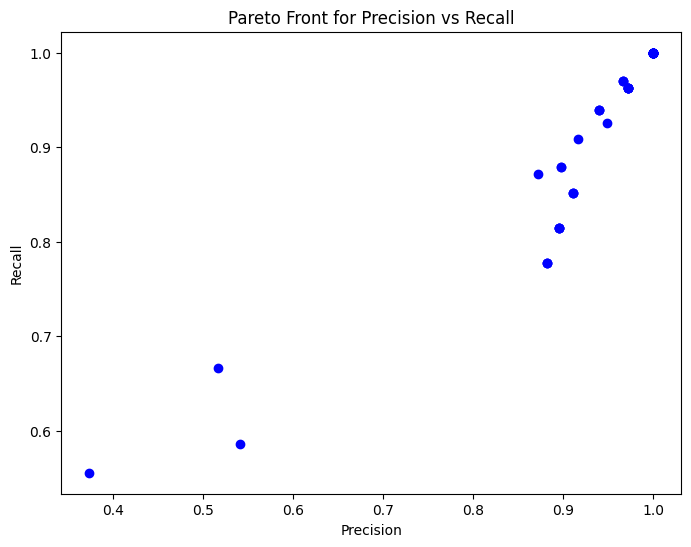

In [1]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# Cargar el conjunto de datos Iris
iris = load_iris()
X, y = iris.data, iris.target

# Convertir las etiquetas a categóricas (one-hot encoding)
y = to_categorical(y)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [ ]:

# Crear el modelo en función de los hiperparámetros propuestos por Optuna
def create_model(trial):
    model = Sequential()
    input_dim = X_train.shape[1]

    # Sugerir el número de capas ocultas y las unidades en cada capa
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        num_units = trial.suggest_int(f'n_units_l{i}', 4, 128)
        model.add(Dense(num_units, activation=trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh']), input_dim=input_dim if i == 0 else None))

    model.add(Dense(3, activation='softmax'))  # Salida para 3 clases

    # Compilar el modelo
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
    
# Función objetivo que entrena y evalúa el modelo usando Optuna
def objective(trial):
    model = create_model(trial)
    
    # Hiperparámetros adicionales
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 10, 50)

    # Entrenar el modelo
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Predecir y calcular precisión y recall
    y_pred = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
    y_test_classes = tf.argmax(y_test, axis=1).numpy()

    precision = precision_score(y_test_classes, y_pred_classes, average='macro')
    recall = recall_score(y_test_classes, y_pred_classes, average='macro')

    # Minimizar (1 - precision) y (1 - recall) para maximizar ambas
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)

    return (1 - precision) + (1 - recall)

# Optimización con Optuna (usando el método de dos objetivos)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

    Dataset Iris:
        Cargamos el dataset Iris, que es más pequeño y contiene 150 ejemplos con 4 características.
        Utilizamos one-hot encoding para las etiquetas de las 3 clases (setosa, versicolor, virginica).

    Red Neuronal:
        El modelo tiene un número de capas ocultas y neuronas configurables (optimizados por Optuna).
        La última capa tiene 3 neuronas para clasificar las 3 clases de Iris con activación softmax.

    Función Objetivo Multiobjetivo:
        Se calculan precisión y recall y se optimizan juntos.
        La suma de (1 - precisión) + (1 - recall) se minimiza para maximizar ambos.

    Visualización:
        Usamos optuna.visualization.plot_param_importances() para visualizar la importancia de los hiperparámetros.
        Creamos una función plot_pareto_front() para visualizar el frente de Pareto entre la precisión y el recall.

Explicación de los Resultados:

    Importancia de los Hiperparámetros: Optuna nos permite visualizar qué hiperparámetros tienen el mayor impacto en el rendimiento del modelo.
    Frente de Pareto: Muestra el equilibrio entre precisión y recall, donde se pueden ver los puntos en el gráfico que representan un trade-off entre estos dos objetivos.

In [2]:
# Imprimir los mejores hiperparámetros
print("Best parameters:", study.best_params)
best_trial = study.best_trial
print(f"Best trial precision: {best_trial.user_attrs['precision']}")
print(f"Best trial recall: {best_trial.user_attrs['recall']}")



Best parameters: {'n_layers': 2, 'n_units_l0': 112, 'activation_l0': 'tanh', 'n_units_l1': 12, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 61, 'epochs': 42}
Best trial precision: 1.0
Best trial recall: 1.0


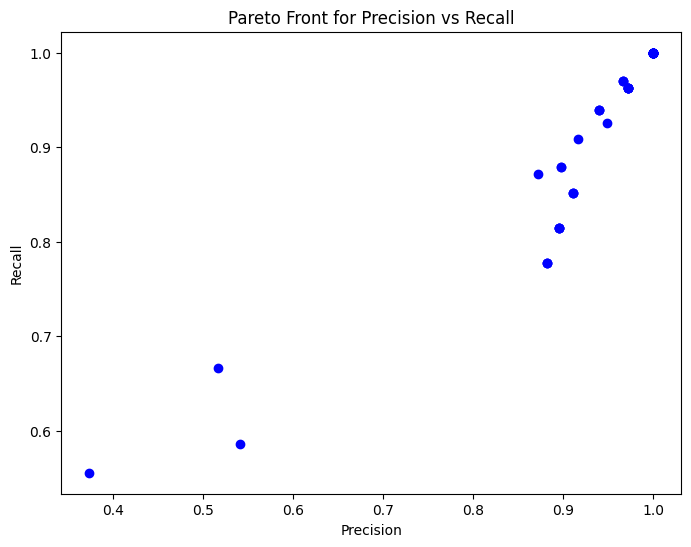

In [3]:
# Mostrar la importancia de los hiperparámetros
optuna.visualization.plot_param_importances(study)

# Mostrar el frente de Pareto entre precision y recall
def plot_pareto_front(study):
    trials = study.trials
    precisions = [trial.user_attrs['precision'] for trial in trials]
    recalls = [trial.user_attrs['recall'] for trial in trials]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(precisions, recalls, c='blue')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Pareto Front for Precision vs Recall')
    plt.show()

plot_pareto_front(study)